In [1]:
import numpy as np
from numpy.lib.recfunctions import rec_append_fields
import csv
from pax import core, units

In [5]:
# Load the map text file
with open('s1xyzmap-20111215.dat') as lymapfile:
    
    tuples = []
    for i, row in enumerate(lymapfile):
        if i == 0:
            continue
        tuples.append(tuple(map(float, row.split())))
        
    data = np.array(tuples, dtype=[('z', int), 
                                   ('t', int),
                                   ('r', int),
                                   ('zmid', float),
                                   ('tmid', float),
                                   ('rmid', float),
                                   ('ly', float),
                                   ('errly', float),])

# Convert to pax units
for field in ('z', 'r', 'zmid', 'rmid'):
    data[field] = data[field].astype(np.float) * units.mm
    
# Convert (r, theta) to (x, y)
data = rec_append_fields(data, 'xmid', data['rmid'] * np.cos(data['tmid']))
data = rec_append_fields(data, 'ymid', data['rmid'] * np.sin(data['tmid']))

In [6]:
# Normalize the average correction to 0
data['ly'] /= data['ly'].mean()

In [7]:
# Write the map to JSON
import textwrap
desc =  textwrap.dedent("""
                        The XENON100 S1 mean light yield map used in Xerawdp 0.4.5.
                        Extracted from data by Cecilia in 2011,
                        see xenon:xenon100:analysis:cecilia:s13dcorrectionmap.
                        Ripped from s1xyzmap-20111215.dat by Jelle, October 2015.
                        """[1:])
import time
mapd = dict(name='XENON100 S1(x,y,z) relative light yield map',
            description=desc,
            coordinate_system=np.vstack((data['xmid'], data['ymid'], data['zmid'])).T.tolist(),
            map=(data['ly']).tolist(),
            irregular=True,
            timestamp=time.time())

import json
with open('s1_xyz_XENON100_xerawdp045.json', mode='w') as outfile:
    json.dump(mapd, outfile)

# 3d Scatter

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


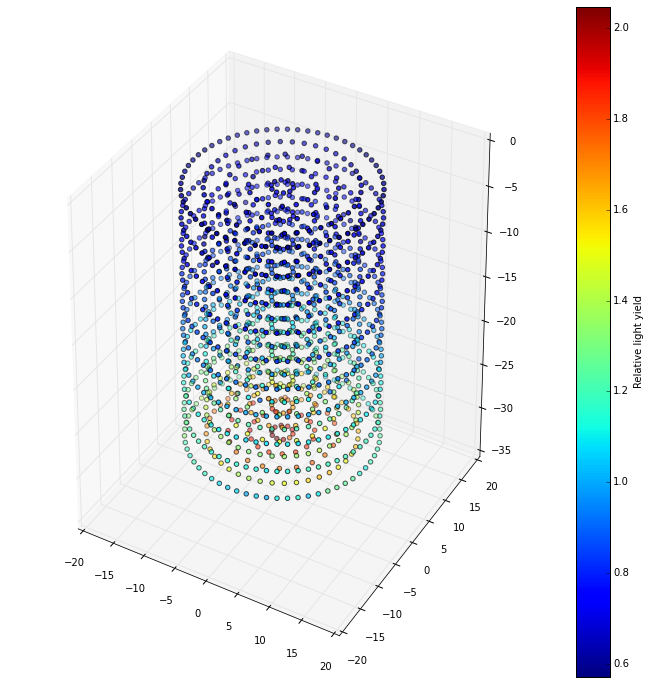

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data['xmid'], data['ymid'], data['zmid'],
                c=data['ly'])
plt.colorbar(sc, label='Relative light yield')
plt.show()

Now we'll plot the map using pax, to verify everything went correctly. Note this picks up the version of the map we just placed in the current directory, rather than the versionin pax/data!

In [25]:
mypax = core.Processor(config_names='XENON100', config_dict=dict(pax=dict(output='Dummy.DummyOutput')))
s1map = mypax.simulator.s1_light_yield_map

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


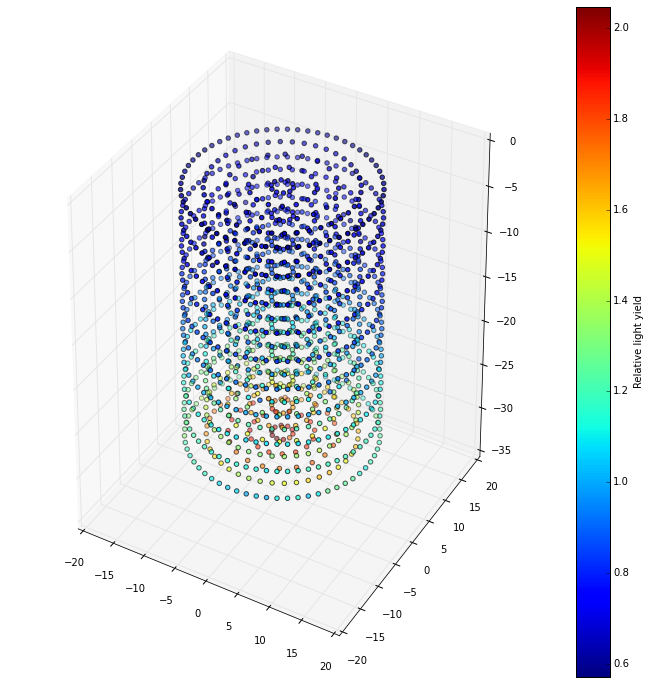

In [28]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib qt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
points = []
values = []
for i in tqdm(range(len(data['xmid']))):
    points.append((data[i]['xmid'], data[i]['ymid'], data[i]['zmid']))
    values.append(s1map.get_value(*points[-1]))
points = np.array(points)
values = np.array(values)
                          
sc = ax.scatter(*points.T, c=values)
plt.colorbar(sc, label='Relative light yield')
plt.show()

# Z-slices

In [ ]:
# Z-slices of map (compare with gallery 5 in Cecilia's note)
points = {}
for z in np.unique(data['zmid']):
    plt.figure(figsize=(12, 10))
    for r in np.unique(data['rmid']):    
        this_data = data[(data['rmid'] == r) & (data['zmid'] == z)]
        plt.errorbar(this_data['tmid'], this_data['ly'], yerr=this_data['errly'], 
                     label='r=%s cm' % (r/10))
    plt.xlabel('Theta (degrees)')
    plt.ylabel('Light yield')
    plt.legend()
    plt.title('z = %s cm' % (z/10))
    plt.show()